In [1]:
import chainer
import numpy as np

from chainer import Variable

from chainer import optimizers

from chainer import functions as F

from chainer.links.model.vision.vgg import prepare

import cupy as xp

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import json

import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
content_image = Image.open('./ai_paint.png')
style_image = Image.open('./style0.png')

content_data = np.asarray(content_image)
style_data = np.asarray(style_image)

# input images

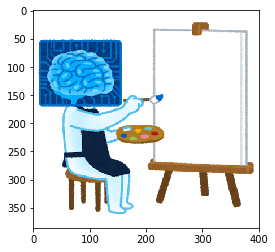

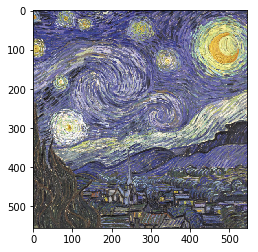

In [3]:
plt.imshow(content_data)
plt.show()
plt.imshow(style_data)
plt.show()

In [4]:
model = chainer.links.VGG16Layers()

model = model.to_gpu()

# generate initial image

In [5]:
gen_image = np.random.randn(224, 224, 3)

gen_image = gen_image - gen_image.min()
gen_image /= gen_image.max()

gen_image *= 255.

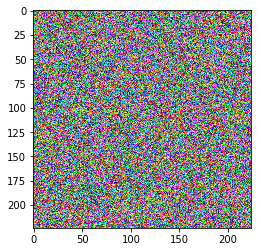

In [6]:
plt.imshow(gen_image)

(array([4.4000e+01, 6.6200e+02, 5.5480e+03, 2.3433e+04, 4.7139e+04,
        4.5977e+04, 2.1992e+04, 5.1270e+03, 5.5800e+02, 4.8000e+01]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

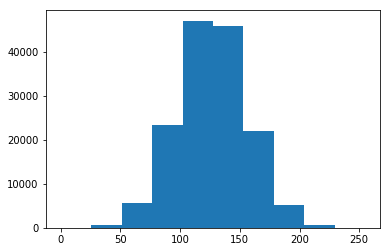

In [7]:
plt.hist(gen_image.reshape(-1))

In [8]:
img_h = 224
img_w = 224

def gram_M(x):
    shape = x.shape
    features = F.reshape(x, (shape[1], -1))
    gram = F.linear(features, features)
    return gram.reshape(1, shape[1], shape[1])

def style_loss(style, comb):
    S = gram_M(style)
    C = gram_M(comb)
    channels = 3
    size = img_w * img_h
    return F.sum(F.square(S - C) / (4. * (channels ** 2) * (size ** 2)))

def content_loss(base, comb):
    return F.sum(F.square(comb - base))

def total_varitaion_loss(x):
    a = F.square(x[:, :, :img_w-1, :img_h-1] - x[:, :, 1:, :img_h -1])
    b = F.square(x[:, :, :img_w-1, :img_h-1] - x[:, :, :img_w -1, 1:])
    return F.sum(a + b)

def loss_func(x, inputs, base, style):
    assert isinstance(x, dict)
    assert isinstance(base, dict)
    assert isinstance(style, dict)
    
    total_varitaion_weight = 1.
    style_weight = 1. / len(styles)
    content_weight = 0.025
    # content loss
    loss = Variable(xp.zeros(()).astype(np.float32))
    for layer in base:
        loss += content_weight * content_loss(base[layer], x[layer])
    
    for layer in style:
        loss += style_weight * style_loss(style[layer], x[layer])
    
    loss += total_varitaion_weight * total_varitaion_loss(inputs)
    return loss

In [9]:
def decode_vgg16(x):
    x = x.transpose((1, 2, 0))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
#     x = np.clip(x, 0, 255)
    x[x < 0] = 0
    x[x > 255.] = 255
    return x

In [10]:
content_data = content_data[:, : ,:3]
style_data = style_data[:, :, :3]

In [11]:
gen_image = np.random.randn(224, 224, 3)

gen_image = gen_image - gen_image.min()
gen_image /= gen_image.max()

gen_image *= 255.

In [12]:
model.to_gpu()

content_layer = ['conv4_2']
content = model.extract(content_data[np.newaxis, :], content_layer)

style_layer = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
styles = model.extract(style_data[np.newaxis, :], style_layer)
list_layer = content_layer + style_layer

In [67]:
l = chainer.links.Parameter(prepare(gen_image)[np.newaxis, :])
l.to_gpu()

In [68]:
#opt = optimizers.SGD(lr=0.00001)
opt = optimizers.AdaGrad(lr=2)
#opt = optimizers.RMSprop(lr=0.4)
opt.setup(l)
l.cleargrads()

0 loss: 25559843000.0


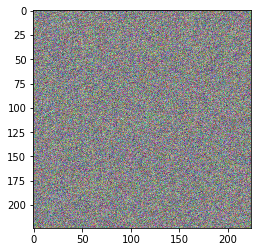

1 loss: 22380583000.0
2 loss: 19693249000.0
3 loss: 17443035000.0
4 loss: 15536073000.0
5 loss: 13900540000.0
6 loss: 12485744000.0
7 loss: 11254675000.0
8 loss: 10179700000.0
9 loss: 9240674000.0
10 loss: 8422453000.0
11 loss: 7711585300.0
12 loss: 7097797000.0
13 loss: 6571951600.0
14 loss: 6123687400.0
15 loss: 5745458000.0
16 loss: 5429371400.0
17 loss: 5167298600.0
18 loss: 4952961000.0
19 loss: 4780467000.0
20 loss: 4643741700.0
21 loss: 4537860600.0
22 loss: 4457499600.0
23 loss: 4398014500.0
24 loss: 4355797500.0
25 loss: 4327260700.0
26 loss: 4309520400.0
27 loss: 4299311600.0
28 loss: 4293863400.0
29 loss: 4290928000.0
30 loss: 4289032700.0
31 loss: 4286490000.0
32 loss: 4282218000.0
33 loss: 4275447000.0
34 loss: 4265038300.0
35 loss: 4250569700.0
36 loss: 4231628500.0
37 loss: 4208236500.0
38 loss: 4180405000.0
39 loss: 4147974100.0
40 loss: 4111429600.0
41 loss: 4071339800.0
42 loss: 4028063700.0
43 loss: 3981949400.0
44 loss: 3933536500.0
45 loss: 3883231500.0
46 loss: 38

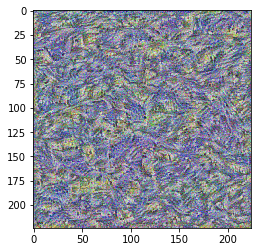

101 loss: 2481540600.0
102 loss: 2469639400.0
103 loss: 2457659100.0
104 loss: 2445681400.0
105 loss: 2433734000.0
106 loss: 2421844500.0
107 loss: 2410046500.0
108 loss: 2398360000.0
109 loss: 2386845400.0
110 loss: 2375517700.0
111 loss: 2364453000.0
112 loss: 2353655600.0
113 loss: 2343161600.0
114 loss: 2332992500.0
115 loss: 2323134000.0
116 loss: 2313568000.0
117 loss: 2304327400.0
118 loss: 2295408400.0
119 loss: 2286827000.0
120 loss: 2278595300.0
121 loss: 2270718000.0
122 loss: 2263196400.0
123 loss: 2256023600.0
124 loss: 2249208800.0
125 loss: 2242705400.0
126 loss: 2236519000.0
127 loss: 2230656800.0
128 loss: 2225130800.0
129 loss: 2219903000.0
130 loss: 2214968800.0
131 loss: 2210291700.0
132 loss: 2205853700.0
133 loss: 2201644500.0
134 loss: 2197664800.0
135 loss: 2193866200.0
136 loss: 2190241300.0
137 loss: 2186787800.0
138 loss: 2183476500.0
139 loss: 2180282000.0
140 loss: 2177134600.0
141 loss: 2174035200.0
142 loss: 2170982000.0
143 loss: 2167955000.0
144 loss: 2

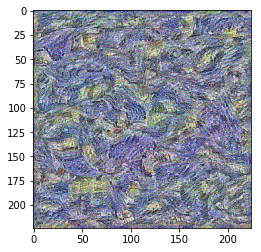

201 loss: 1879947500.0
202 loss: 1876449500.0
203 loss: 1873037400.0
204 loss: 1869697400.0
205 loss: 1866426100.0
206 loss: 1863202800.0
207 loss: 1860014100.0
208 loss: 1856855000.0
209 loss: 1853721600.0
210 loss: 1850597800.0
211 loss: 1847465200.0
212 loss: 1844318300.0
213 loss: 1841153200.0
214 loss: 1837953300.0
215 loss: 1834703900.0
216 loss: 1831404700.0
217 loss: 1828072300.0
218 loss: 1824683800.0
219 loss: 1821231100.0
220 loss: 1817713500.0
221 loss: 1814138200.0
222 loss: 1810508000.0
223 loss: 1806814000.0
224 loss: 1803053400.0
225 loss: 1799235300.0
226 loss: 1795370400.0
227 loss: 1791446400.0
228 loss: 1787463200.0
229 loss: 1783436500.0
230 loss: 1779359900.0
231 loss: 1775239300.0
232 loss: 1771086200.0
233 loss: 1766916600.0
234 loss: 1762731300.0
235 loss: 1758532600.0
236 loss: 1754328700.0
237 loss: 1750129800.0
238 loss: 1745946100.0
239 loss: 1741779600.0
240 loss: 1737649500.0
241 loss: 1733563900.0
242 loss: 1729528400.0
243 loss: 1725544400.0
244 loss: 1

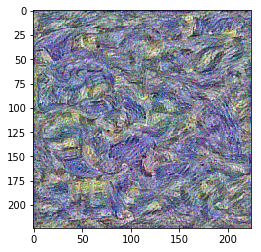

301 loss: 1580389800.0
302 loss: 1577896400.0
303 loss: 1575388900.0
304 loss: 1572868000.0
305 loss: 1570337700.0
306 loss: 1567799700.0
307 loss: 1565257000.0
308 loss: 1562707200.0
309 loss: 1560151700.0
310 loss: 1557599700.0
311 loss: 1555048400.0
312 loss: 1552502400.0
313 loss: 1549972000.0
314 loss: 1547461400.0
315 loss: 1544980700.0
316 loss: 1542528300.0
317 loss: 1540103200.0
318 loss: 1537701100.0
319 loss: 1535328500.0
320 loss: 1532984300.0
321 loss: 1530664000.0
322 loss: 1528368100.0
323 loss: 1526106000.0
324 loss: 1523872900.0
325 loss: 1521667300.0
326 loss: 1519488800.0
327 loss: 1517338900.0
328 loss: 1515218300.0
329 loss: 1513129500.0
330 loss: 1511073500.0
331 loss: 1509052700.0
332 loss: 1507059200.0
333 loss: 1505091100.0
334 loss: 1503147500.0
335 loss: 1501233400.0
336 loss: 1499346200.0
337 loss: 1497484300.0
338 loss: 1495645300.0
339 loss: 1493822300.0
340 loss: 1492010500.0
341 loss: 1490209800.0
342 loss: 1488418800.0
343 loss: 1486633000.0
344 loss: 1

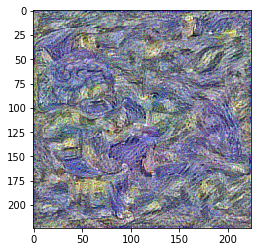

401 loss: 1384016000.0
402 loss: 1382690000.0
403 loss: 1381384800.0
404 loss: 1380102700.0
405 loss: 1378845200.0
406 loss: 1377605800.0
407 loss: 1376382700.0
408 loss: 1375176100.0
409 loss: 1373988200.0
410 loss: 1372817300.0
411 loss: 1371662100.0
412 loss: 1370517800.0
413 loss: 1369385600.0
414 loss: 1368264000.0
415 loss: 1367153700.0
416 loss: 1366054100.0
417 loss: 1364962300.0
418 loss: 1363878300.0
419 loss: 1362795500.0
420 loss: 1361713700.0
421 loss: 1360634000.0
422 loss: 1359555300.0
423 loss: 1358476500.0
424 loss: 1357396200.0
425 loss: 1356315900.0
426 loss: 1355231400.0
427 loss: 1354143600.0
428 loss: 1353052700.0
429 loss: 1351957600.0
430 loss: 1350853400.0
431 loss: 1349742200.0
432 loss: 1348620000.0
433 loss: 1347491500.0
434 loss: 1346357600.0
435 loss: 1345214300.0
436 loss: 1344065500.0
437 loss: 1342916600.0
438 loss: 1341763800.0
439 loss: 1340606500.0
440 loss: 1339447600.0
441 loss: 1338287100.0
442 loss: 1337123500.0
443 loss: 1335955800.0
444 loss: 1

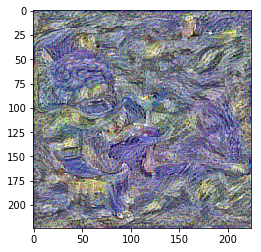

501 loss: 1282676600.0
502 loss: 1281951100.0
503 loss: 1281222500.0
504 loss: 1280489700.0
505 loss: 1279752600.0
506 loss: 1279009800.0
507 loss: 1278260900.0
508 loss: 1277507700.0
509 loss: 1276750100.0
510 loss: 1275986700.0
511 loss: 1275219600.0
512 loss: 1274444400.0
513 loss: 1273662300.0
514 loss: 1272872200.0
515 loss: 1272076200.0
516 loss: 1271272600.0
517 loss: 1270465400.0
518 loss: 1269651500.0
519 loss: 1268830200.0
520 loss: 1268005400.0
521 loss: 1267172400.0
522 loss: 1266333200.0
523 loss: 1265490200.0
524 loss: 1264640600.0
525 loss: 1263790600.0
526 loss: 1262939400.0
527 loss: 1262086000.0
528 loss: 1261227400.0
529 loss: 1260364900.0
530 loss: 1259501000.0
531 loss: 1258637700.0
532 loss: 1257773800.0
533 loss: 1256911100.0
534 loss: 1256050600.0
535 loss: 1255194600.0
536 loss: 1254343600.0
537 loss: 1253495600.0
538 loss: 1252652900.0
539 loss: 1251817300.0
540 loss: 1250991000.0
541 loss: 1250172700.0
542 loss: 1249363300.0
543 loss: 1248561200.0
544 loss: 1

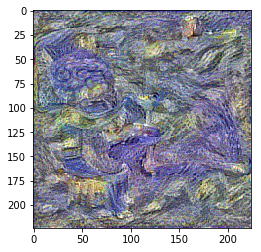

601 loss: 1214219000.0
602 loss: 1213687800.0
603 loss: 1213156400.0
604 loss: 1212623400.0
605 loss: 1212090400.0
606 loss: 1211557100.0
607 loss: 1211022000.0
608 loss: 1210486100.0
609 loss: 1209950500.0
610 loss: 1209414700.0
611 loss: 1208879200.0
612 loss: 1208341200.0
613 loss: 1207803400.0
614 loss: 1207267300.0
615 loss: 1206732800.0
616 loss: 1206196200.0
617 loss: 1205660400.0
618 loss: 1205129000.0
619 loss: 1204598700.0
620 loss: 1204071700.0
621 loss: 1203548900.0
622 loss: 1203028200.0
623 loss: 1202507600.0
624 loss: 1201989900.0
625 loss: 1201474300.0
626 loss: 1200961900.0
627 loss: 1200452900.0
628 loss: 1199947900.0
629 loss: 1199446900.0
630 loss: 1198951000.0
631 loss: 1198459100.0
632 loss: 1197972500.0
633 loss: 1197490300.0
634 loss: 1197012100.0
635 loss: 1196540200.0
636 loss: 1196073000.0
637 loss: 1195609600.0
638 loss: 1195153000.0
639 loss: 1194701600.0
640 loss: 1194254100.0
641 loss: 1193812600.0
642 loss: 1193376900.0
643 loss: 1192946300.0
644 loss: 1

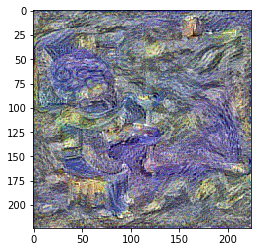

701 loss: 1171035800.0
702 loss: 1170671700.0
703 loss: 1170311300.0
704 loss: 1169952800.0
705 loss: 1169594400.0
706 loss: 1169236200.0
707 loss: 1168879900.0
708 loss: 1168526600.0
709 loss: 1168176000.0
710 loss: 1167828000.0
711 loss: 1167483300.0
712 loss: 1167141100.0
713 loss: 1166801300.0
714 loss: 1166464500.0
715 loss: 1166129700.0
716 loss: 1165798700.0
717 loss: 1165471200.0
718 loss: 1165149000.0
719 loss: 1164831700.0
720 loss: 1164518700.0
721 loss: 1164211200.0
722 loss: 1163908900.0
723 loss: 1163612200.0
724 loss: 1163320000.0
725 loss: 1163031800.0
726 loss: 1162747600.0
727 loss: 1162467100.0
728 loss: 1162190600.0
729 loss: 1161916400.0
730 loss: 1161644500.0
731 loss: 1161375500.0
732 loss: 1161109000.0
733 loss: 1160845800.0
734 loss: 1160584800.0
735 loss: 1160326700.0
736 loss: 1160071700.0
737 loss: 1159819000.0
738 loss: 1159569900.0
739 loss: 1159322400.0
740 loss: 1159075800.0
741 loss: 1158829800.0
742 loss: 1158586200.0
743 loss: 1158345700.0
744 loss: 1

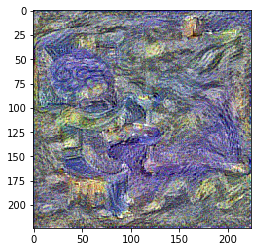

801 loss: 1143514900.0
802 loss: 1143254500.0
803 loss: 1142995000.0
804 loss: 1142737800.0
805 loss: 1142484700.0
806 loss: 1142234100.0
807 loss: 1141986000.0
808 loss: 1141740700.0
809 loss: 1141498900.0
810 loss: 1141258200.0
811 loss: 1141020800.0
812 loss: 1140785800.0
813 loss: 1140553700.0
814 loss: 1140324700.0
815 loss: 1140097300.0
816 loss: 1139872300.0
817 loss: 1139650700.0
818 loss: 1139432700.0
819 loss: 1139217900.0
820 loss: 1139005600.0
821 loss: 1138796300.0
822 loss: 1138590000.0
823 loss: 1138385700.0
824 loss: 1138184400.0
825 loss: 1137985000.0
826 loss: 1137788400.0
827 loss: 1137595900.0
828 loss: 1137406500.0
829 loss: 1137221400.0
830 loss: 1137037400.0
831 loss: 1136855600.0
832 loss: 1136675200.0
833 loss: 1136496500.0
834 loss: 1136317800.0
835 loss: 1136139300.0
836 loss: 1135961700.0
837 loss: 1135786200.0
838 loss: 1135612000.0
839 loss: 1135437800.0
840 loss: 1135264100.0
841 loss: 1135091500.0
842 loss: 1134918900.0
843 loss: 1134746900.0
844 loss: 1

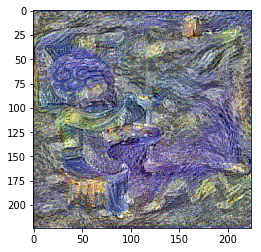

901 loss: 1123041000.0
902 loss: 1122836500.0
903 loss: 1122631400.0
904 loss: 1122427900.0
905 loss: 1122224600.0
906 loss: 1122022100.0
907 loss: 1121820200.0
908 loss: 1121619700.0
909 loss: 1121421700.0
910 loss: 1121224200.0
911 loss: 1121027800.0
912 loss: 1120833800.0
913 loss: 1120641900.0
914 loss: 1120450800.0
915 loss: 1120262100.0
916 loss: 1120075300.0
917 loss: 1119891100.0
918 loss: 1119709400.0
919 loss: 1119529200.0
920 loss: 1119350800.0
921 loss: 1119174500.0
922 loss: 1118998700.0
923 loss: 1118823600.0
924 loss: 1118650600.0
925 loss: 1118480100.0
926 loss: 1118310900.0
927 loss: 1118143600.0
928 loss: 1117976300.0
929 loss: 1117810700.0
930 loss: 1117646600.0
931 loss: 1117483300.0
932 loss: 1117320000.0
933 loss: 1117156700.0
934 loss: 1116994300.0
935 loss: 1116832900.0
936 loss: 1116673000.0
937 loss: 1116513400.0
938 loss: 1116353000.0
939 loss: 1116191500.0
940 loss: 1116029600.0
941 loss: 1115868500.0
942 loss: 1115708400.0
943 loss: 1115548900.0
944 loss: 1

In [69]:
n_epoch = 1000
imgs = []
for epoch in range(n_epoch):
    loss = loss_func(model(l(), layers=list_layer), l(), content, styles)
    loss.backward()
    opt.update()
    print('{} loss: {}'.format(epoch, loss.data))
    show_img = decode_vgg16(xp.asnumpy(l().data[0]))/255.
    imgs.append(show_img)
    if epoch % 100 == 0:
        plt.imshow(show_img)
        plt.show()
        plt.close()

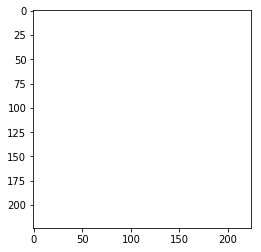

In [70]:
import matplotlib.animation as anime

fig = plt.figure()
ims = []
for n, i in enumerate(imgs):
    im = plt.imshow(i, animated=True)
    ims.append([im])
ani = anime.ArtistAnimation(fig, ims, interval=50, repeat_delay=100, blit=True)

In [71]:
fname = 'anime'
cnt = 0
fpath = fname + str(cnt) + '.mp4'
while os.path.exists(fpath):
    cnt += 1
    fpath = fname + str(cnt) + '.mp4'
ani.save(fpath)


In [72]:
image = Image.fromarray((255*show_img).astype(np.uint8))

image.save('generated_style_image.jpg')